# Diabetes Dataset(Binary Classification)

## Initial Imports & Loading Datasets

In [1]:
# Importing packages

import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import imblearn
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import RandomOverSampler

2025-05-24 12:50:36.579872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748071236.607560   97088 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748071236.617844   97088 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748071236.643758   97088 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748071236.643807   97088 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748071236.643810   97088 computation_placer.cc:177] computation placer alr

In [2]:
# Load the dataset

dataset = pd.read_csv('datasets/diabetes.csv')
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Visualizing Data

In [3]:
dataset.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [1]:
## Visualizing Data

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten() 

for i, label in enumerate(dataset.columns[:-1]):
    ax = axes[i]
    ax.hist(dataset[dataset['Outcome'] == 1][label], 
            bins=15, color='blue', label='Diabetes', 
            density=True, alpha=0.5)
    ax.hist(dataset[dataset['Outcome'] == 0][label], 
            bins=15, color='red', label='No Diabetes', 
            density=True, alpha=0.5)
    ax.set_title(label)
    ax.set_ylabel("Probability")
    ax.set_xlabel(label)
    ax.legend()

axes[8].bar(['Diabetes', 'No Diabetes'], 
        [len(dataset[dataset['Outcome'] == 1]['Glucose']), 
         len(dataset[dataset['Outcome'] == 0]['Glucose'])])
axes[8].set_title('Diabetes vs No Diabetes')
axes[8].set_ylabel('Number')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()



NameError: name 'plt' is not defined

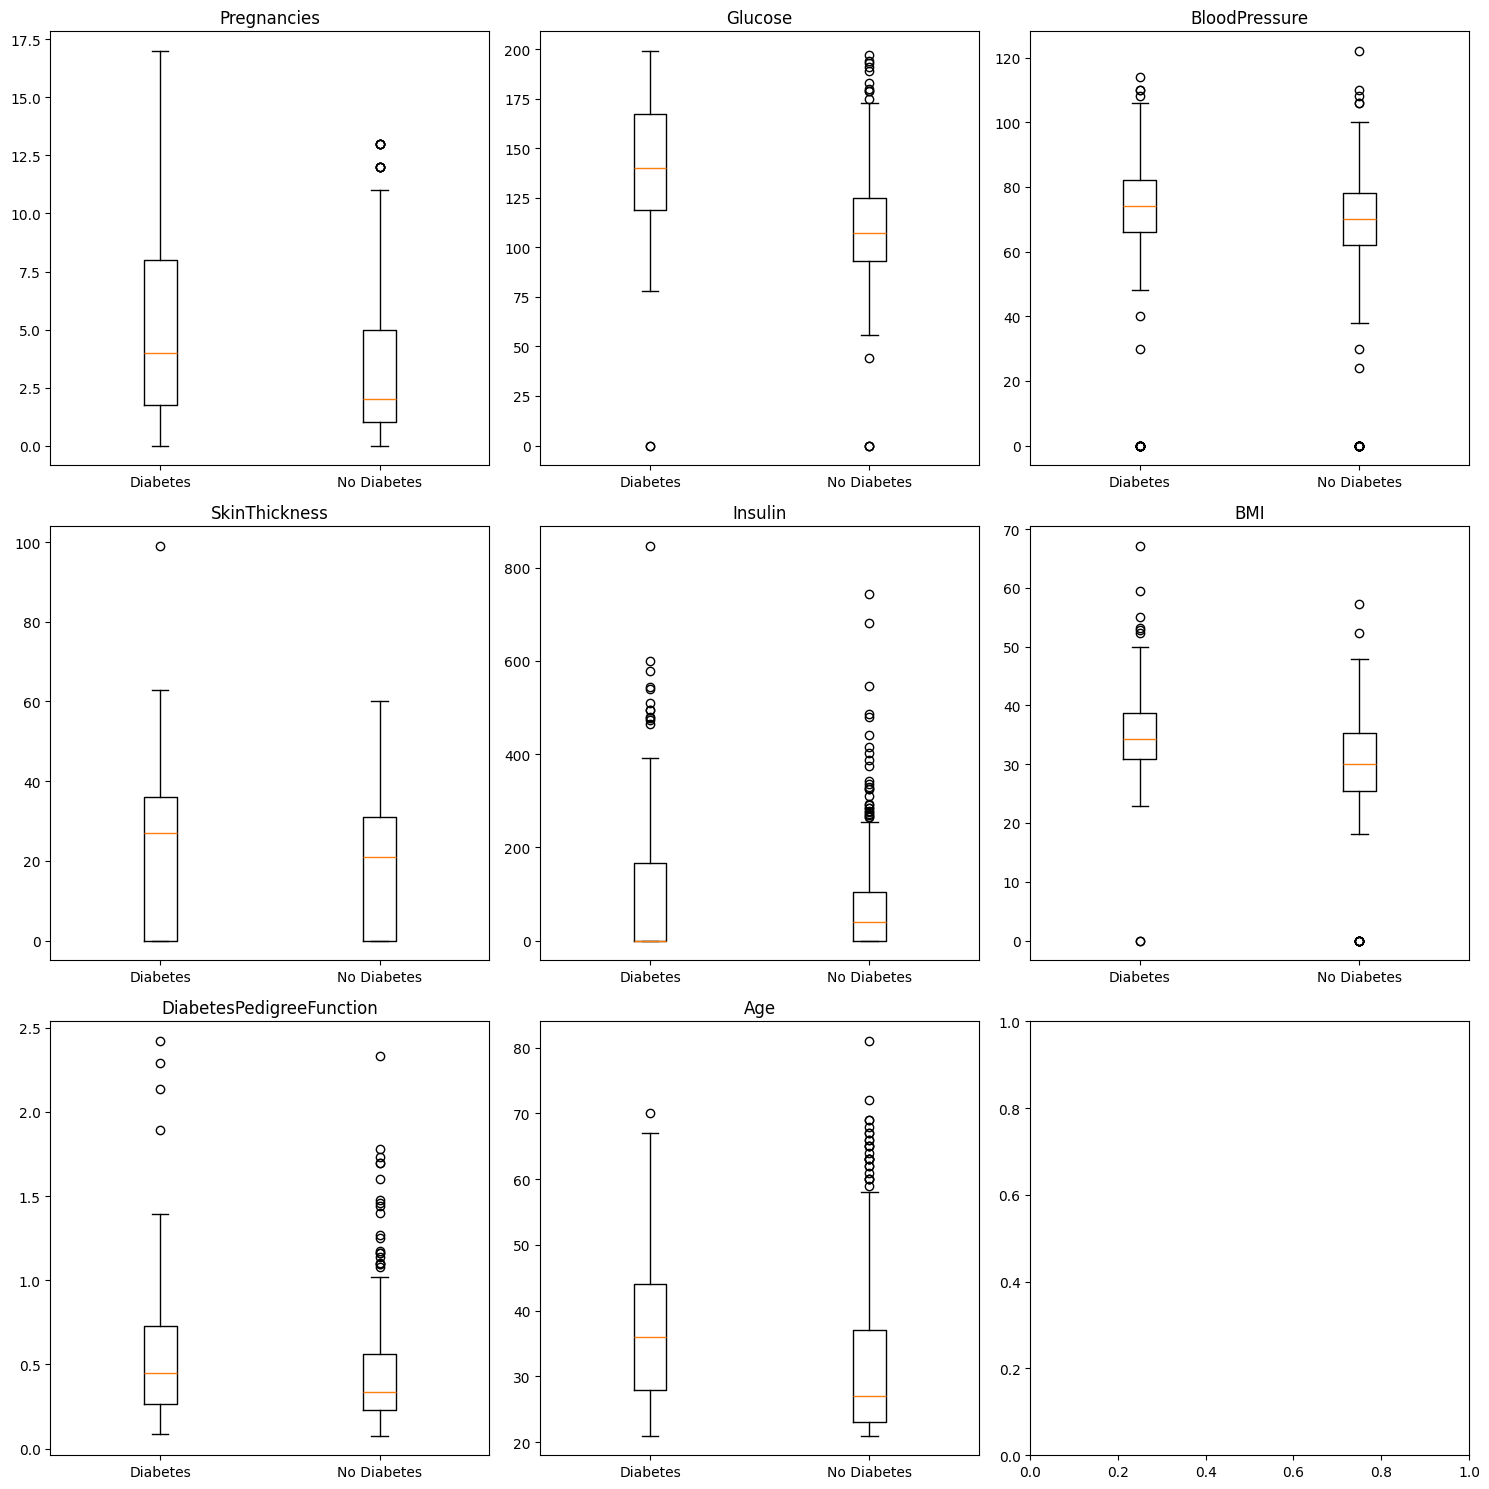

In [4]:
# Boxplots, best way to check for outliers

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten() 

for i, label in enumerate(dataset.columns[:-1]):
    ax = axes[i]
    ax.boxplot([dataset[dataset['Outcome'] == 1][label], dataset[dataset['Outcome'] == 0][label]], tick_labels=['Diabetes', 'No Diabetes'])
    ax.set_title(label)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

- There seem to be missing values here(0s) which need to be replaced. Since there are a lot of outliers,  mean will be affected but not median, hence we go with median as the replaced value. Mean works better for normal distributions and lower outlier scenarios.
- There are a few outliers for certain features, they need to be handled properly.
   - **Turkey's Rule**: Also called the Interquartile Range(IQR) rule. Here we calculate the range out of which the data points can be called outliers.
         IQF = (Q3 - Q1)
         Lower Boundary = (Q1 - 1.5 * IQR)
         Upper Boundary = (Q3 + 1.5 * IQR). Other values instead of 1.5 like 2, 3 can also be used.
   - **Drop the outliers**: Self explanatory. Can be done if a lot of rows, but not recommended as vulnerable record may get lost. Use only when you know that the data point is an incorrect rading, or when outliers represent data that is of no need(doesn't belong to the population), like outlier is data of a child but study is of adults.
   - **Winsorize Method**: Limit Outliers by setting upper and lower limits. Especially useful for medical data where extreme but valid cases exist.
   - **Log Transformation**: Mostly used on highly right-skewed data. It reduces the skewness of datya and tries to make it normal, which neural networks like a lot. However, log transformation may make the data more skewed in some cases. So be carefulwhen using it.
- Divide the data into 3 sets - training, validation, test.
- Also the dataset seems to imbalanced with there being much more cases of No diabetes than Diabetes. Oversampling needs to be done, but only on the training set.
- Each feature has different range. We need to scale the training data properly.

## Data Preprocessing

### Remvoing Missing Values

In [5]:
# Removing Missing Values(0s) in columns that make sense

# Replacing 0 with Median to denote missing values
missing = ['Glucose', 'BloodPressure', 'Insulin', 'BMI', 'SkinThickness']

for col in missing:
    dataset[col] = dataset[col].replace(0, dataset[col].median())

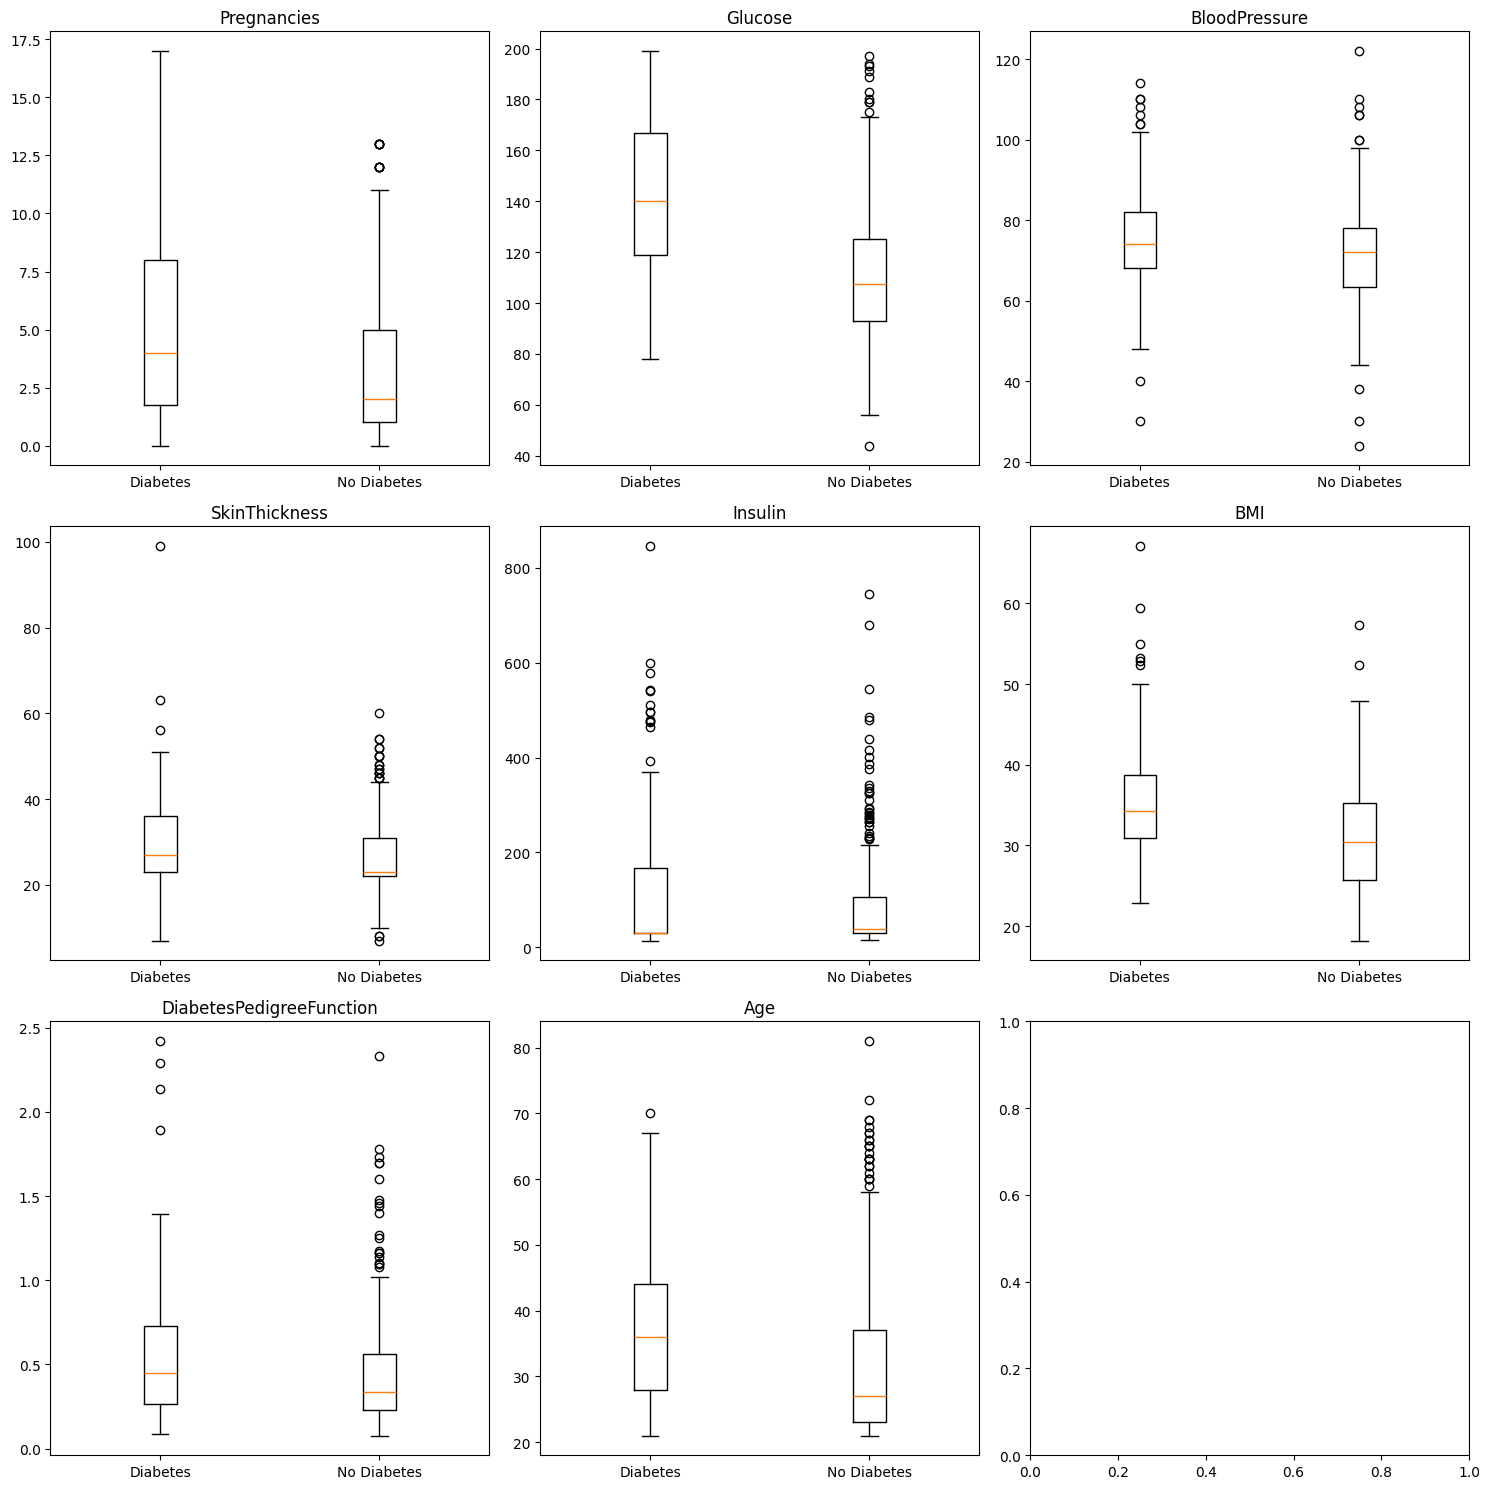

In [6]:
# Boxplots, best way to check for outliers
# To show no NaN values are left.

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten() 

for i, label in enumerate(dataset.columns[:-1]):
    ax = axes[i]
    ax.boxplot([dataset[dataset['Outcome'] == 1][label], dataset[dataset['Outcome'] == 0][label]], tick_labels=['Diabetes', 'No Diabetes'])
    ax.set_title(label)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

### Handling Outliers

Taking care of outliers:

1. Pregnancies: **Keep as is**. The dataset may be right skewed but thats normal, its expected for women to have lower number of pregnancies.
2. Glucose: There is a strong chance the outliers here show hyperglycemia in diabetic patients. We want to preserve this information without letting it have extreme influence, this can be done by **Winsorization**. Log Transform will normalize the data which will lead to loss of iunformation.
3. BloodPressure: Outliers may be measurement errors? **Winsorize** both ends.
4. SkinThickness: Right-Skewed. Use **Log Transform**.
5. Insulin: Heavily Right Skewed. **Log Transform** to be used.
6. BMI: Moderately Skewed, Use **Winsorization**.
7. DiabetesPedigreeFunction: **Winsorization**. This function contains genetic risk information where extreme values may represent legitimate hereditary factors. Mild winsorization preserves most information while reducing influence of extreme outliers
8. Age: **Keep as is**. Cant be changed.

In [7]:
# Applying Outlier Handling Techniques

# Winsorization
for label in ['Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Insulin']:
    lower = dataset[label].quantile(0.05)
    upper = dataset[label].quantile(0.95)
    dataset[label] = dataset[label].clip(lower, upper)

# Log Transform
# It won't work if the dataset has -ve values, which can be introduced after MICE Imputation
# So clip these ones

# dataset['Insulin'] = dataset['Insulin'].clip(lower=2)

for label in ['SkinThickness', ]:
    dataset[label] = np.log1p(dataset[label])

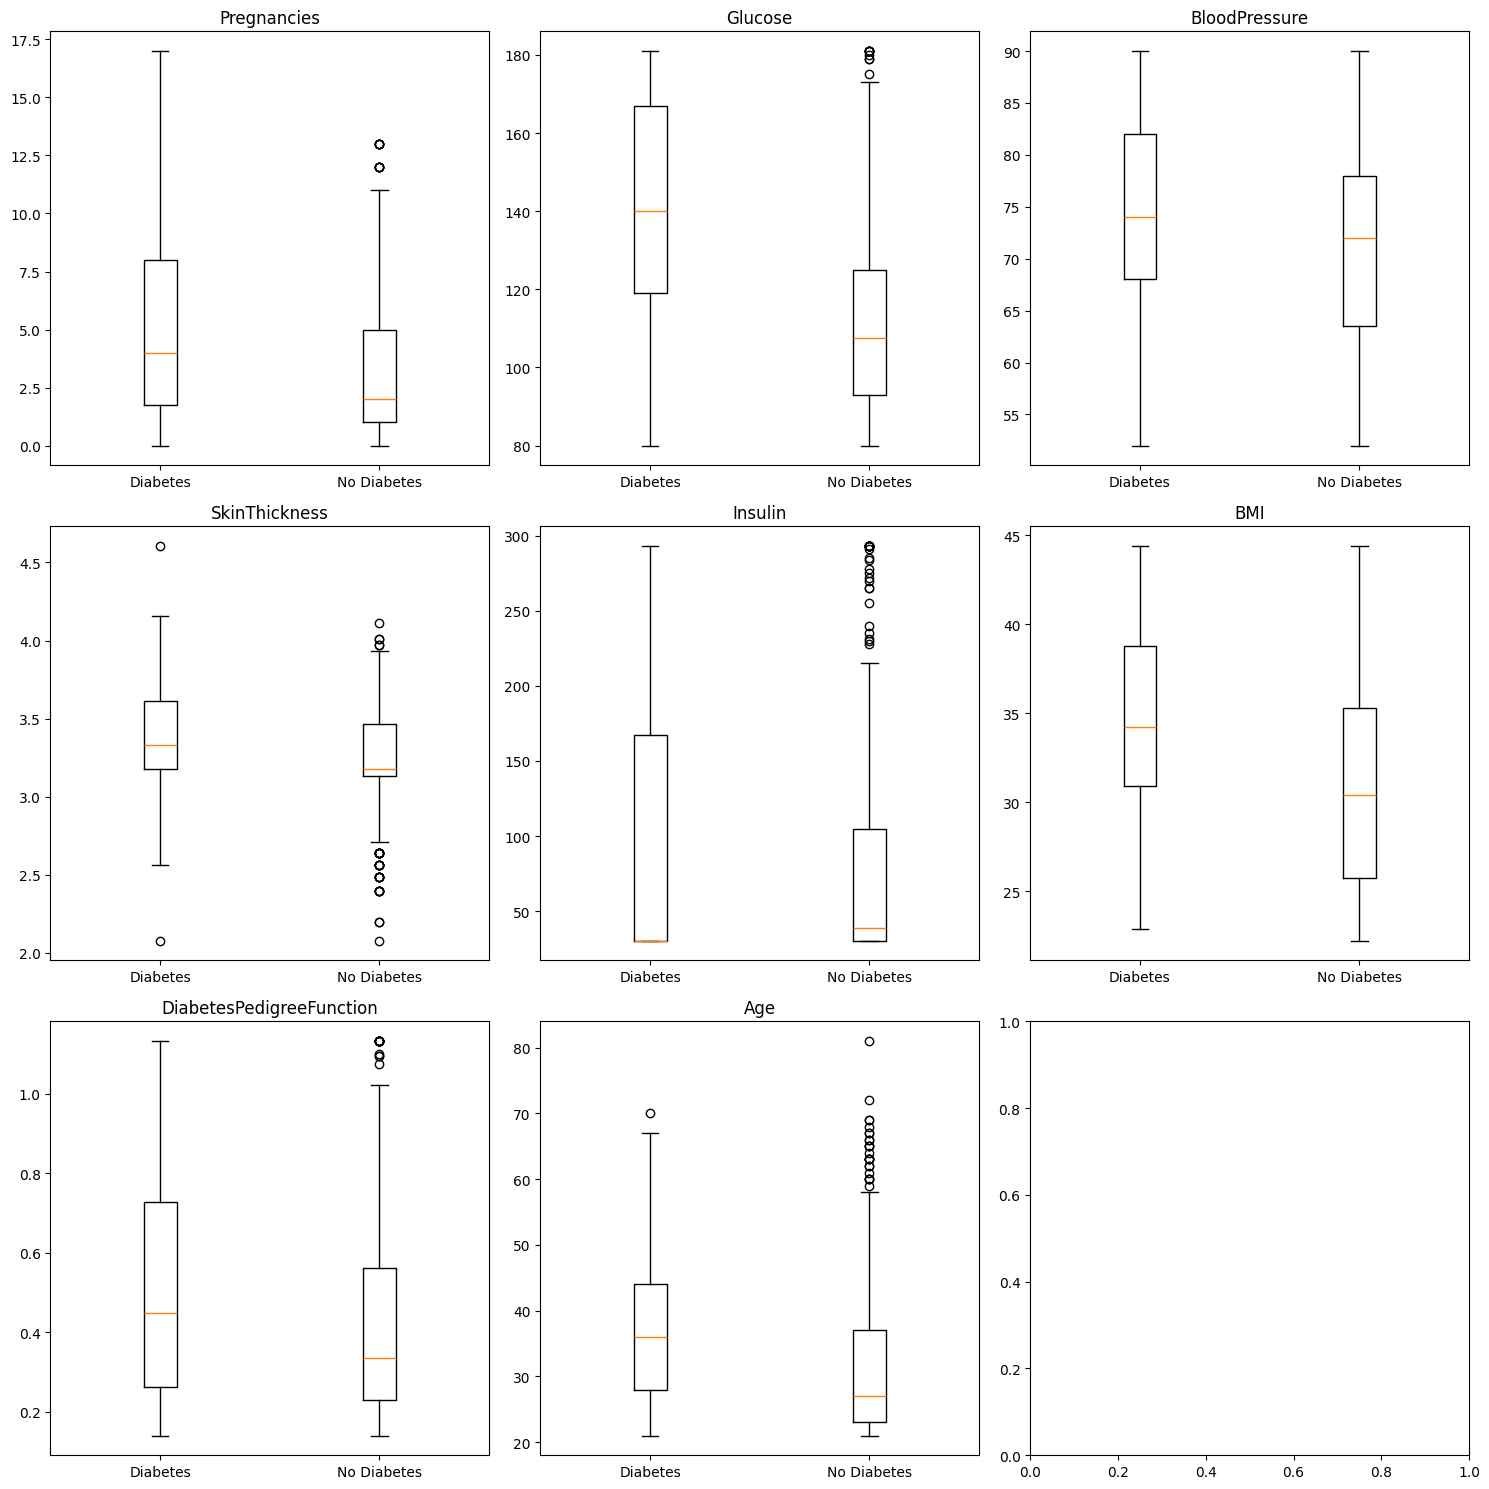

In [8]:
# Boxplots, best way to check for outliers

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten() 

for i, label in enumerate(dataset.columns[:-1]):
    ax = axes[i]
    ax.boxplot([dataset[dataset['Outcome'] == 1][label], dataset[dataset['Outcome'] == 0][label]], tick_labels=['Diabetes', 'No Diabetes'])
    ax.set_title(label)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

### Dataset Splitting

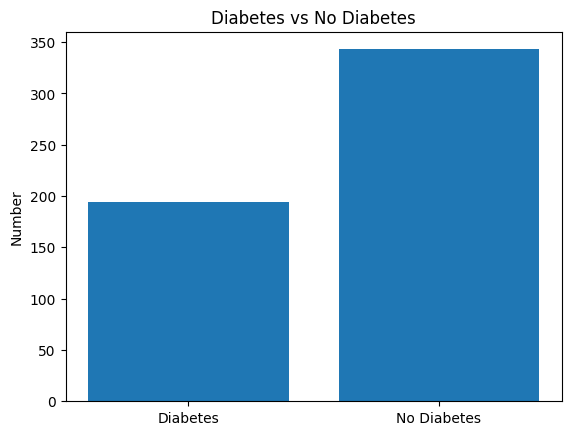

In [9]:
# Divide the dataset into features and targets

x = dataset.drop('Outcome', axis=1)
y = dataset['Outcome']

x_train, x_new, y_train, y_new = train_test_split(x, y, test_size = 0.3, random_state = 0)
x_valid, x_test, y_valid, y_test = train_test_split(x_new, y_new, test_size = 0.5, random_state = 0)

temp = pd.concat([x_train, y_train], axis = 1)
plt.bar(['Diabetes', 'No Diabetes'], 
        [len(temp[temp['Outcome'] == 1]['Glucose']), 
         len(temp[temp['Outcome'] == 0]['Glucose'])])
plt.title('Diabetes vs No Diabetes')
plt.ylabel('Number')

plt.show()

### Oversampling the training set

Oversampling/Undersampling is only done on the training data. Doing it on the other sets may cause data leakage. Thus, the data is divided first and then sampled.

In [10]:
# Oversampling the training set

sampler = RandomOverSampler(sampling_strategy = 1)
x_train, y_train = sampler.fit_resample(x_train, y_train)

y_train.value_counts

<bound method IndexOpsMixin.value_counts of 0      1
1      0
2      0
3      1
4      1
      ..
681    1
682    1
683    1
684    1
685    1
Name: Outcome, Length: 686, dtype: int64>

Text(0, 0.5, 'Number')

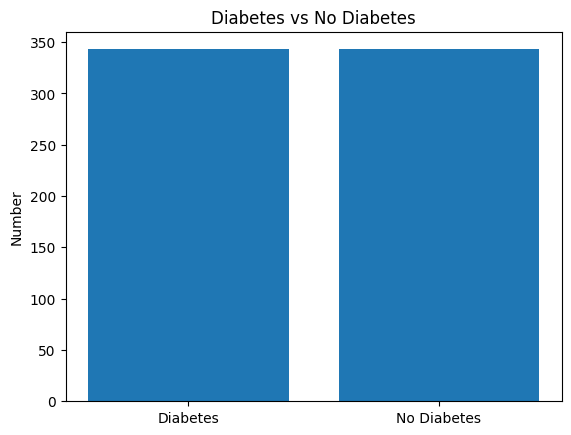

In [11]:
temp = pd.concat([x_train, y_train], axis = 1)
plt.bar(['Diabetes', 'No Diabetes'], 
        [len(temp[temp['Outcome'] == 1]['Glucose']), 
         len(temp[temp['Outcome'] == 0]['Glucose'])])
plt.title('Diabetes vs No Diabetes')
plt.ylabel('Number')

### Feature Scaling

- Standardization is a common requirement for many ML algorithms as they start behaving badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.
- In practice we often ignore the shape of the distribution and just transform the data to center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation.

1. StandardScaler: x_new = (x_old - mean) / (std deviation). This method is vulnerable to outliers as mean is affected by outliers. Zero Mean and Unit Variance, perfect for Neural Network Architectures.
2. RobustScaler: x_new = (x_old - median) / (IQR). This uses median and is thus not affected by outliers. Since IQR is used as well, it absorbs the effects of outliers while scaling. If you have outliers that might affect the results and you don't want to remove them, use this.
3. MinMaxScaler: x_new = (x_old - min_value) / (max_value - min_value). It sets data from 0 to 1. Not suitable when outliers are present as max and min values are used.
4. MaxAbsScaler: x_new = x_old / |max_value|. If data has negative values, it sets data between -1 and 1. Since max value is used, it is not suitable for outliers.

We will use a StandardScaler here. **UPDATE**: Changed to RobustScaler as it gives a much better Performance boost compared StandardScaler.

In [12]:
# Feature Scaling

scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)

In [13]:
x_valid = scaler.transform(x_valid)
x_test = scaler.transform(x_test)

In [14]:
print(x_train)

[[-0.5         0.56544503  1.28571429 ...  1.01994302 -0.03921569
  -0.58823529]
 [-0.33333333 -0.85863874 -0.28571429 ... -1.24387464  0.62222222
  -0.23529412]
 [-0.16666667 -0.04188482 -0.14285714 ...  0.41595442 -0.12026144
  -0.23529412]
 ...
 [ 0.5         0.5026178   0.         ...  0.05128205  0.63006536
   1.11764706]
 [ 1.16666667  0.10471204 -0.71428571 ...  0.91737892  0.14379085
   0.41176471]
 [-0.16666667  0.46073298  0.         ... -0.64387464 -0.38169935
  -0.17647059]]


In [15]:
print(x_valid)

[[ 0.16666667  0.62827225  0.          0.41084724  0.68546638 -0.21082621
  -0.1254902   0.35294118]
 [-0.16666667 -0.2513089  -0.28571429 -0.35199531  0.40780911  0.10826211
  -0.18562092 -0.29411765]
 [ 0.          1.19371728 -0.14285714  0.59613946 -0.14316703  0.1994302
  -0.37908497 -0.35294118]
 [ 0.5        -0.46073298  0.71428571 -0.22980525 -0.14316703 -0.26780627
  -0.53856209  0.29411765]
 [ 0.          0.71204188  0.28571429  1.0129618   1.71800434 -0.17663818
   1.21568627 -0.17647059]
 [-0.33333333 -0.46073298  0.14285714 -0.22980525 -0.14316703  0.72364672
  -0.24313725  0.64705882]
 [ 0.5         1.19371728  1.28571429 -0.22980525 -0.14316703  0.87179487
   1.95254902  0.82352941]
 [-0.5        -0.48167539 -0.57142857 -1.05574996 -0.14316703 -1.24387464
  -0.3503268  -0.58823529]
 [-0.5         0.48167539  0.92857143  2.15108311 -0.14316703  1.0997151
  -0.02875817 -0.41176471]
 [ 0.83333333  0.39790576 -0.42857143 -0.22980525 -0.14316703  0.1994302
  -0.64222222  0.588

In [16]:
print(x_test)

[[-0.5         0.77486911 -1.42857143 -0.22980525 -0.14316703 -1.24387464
  -0.34509804  2.        ]
 [ 0.66666667 -0.92146597  0.42857143 -0.22980525 -0.14316703 -0.06267806
   0.0130719   0.58823529]
 [ 0.83333333 -0.92146597 -0.14285714  1.30768526  0.01735358  0.24501425
   0.83398693  0.47058824]
 [ 0.5         0.          0.         -0.22980525 -0.14316703 -0.63247863
  -0.04705882 -0.11764706]
 [-0.33333333 -0.35602094 -1.42857143 -0.75325645 -0.14316703 -0.55270655
  -0.53594771 -0.11764706]
 [ 0.33333333  0.31413613 -0.57142857  0.93429844  0.80694143 -0.51851852
   0.06535948 -0.29411765]
 [ 0.33333333 -0.7539267  -0.42857143 -0.47961778 -0.14316703 -0.997151
  -0.11503268 -0.05882353]
 [ 0.          0.02094241 -1.         -0.22980525 -0.14316703 -0.17663818
  -0.61437908 -0.41176471]
 [-0.33333333  0.          0.14285714  1.0129618  -0.14316703 -0.60968661
  -0.64222222 -0.05882353]
 [-0.5         0.85863874  1.28571429  0.77019475  2.13449024  1.28148148
   0.10718954 -0.47

## Model Creation and Training

In [17]:
# Model Creation

model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=35, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(units=25, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(units=15, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             loss = tf.keras.losses.BinaryCrossentropy(),
             metrics=['accuracy'])

I0000 00:00:1748071246.577741   97088 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2573 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [19]:
# Evaluate initial performance without any training

model.evaluate(x_train, y_train)

I0000 00:00:1748071247.392287   97184 service.cc:152] XLA service 0x7da1e0016a90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748071247.392333   97184 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-05-24 12:50:47.430160: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748071247.507637   97184 cuda_dnn.cc:529] Loaded cuDNN version 90300


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3701 - loss: 1.3352

I0000 00:00:1748071247.954284   97184 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3948 - loss: 1.3268


[1.2918269634246826, 0.5]

### Important Points

- **Iterations**: Number of batches needed to complete one Epoch.
- **Batch Size**: Number of training samples used in one Iteration.
- **Epoch**: One full cycle through the entire dataset.
- Number of steps per Epoch = Number of training examples / Batch Size
- After every Iteration, weights are re-evaluated and updated. Batching is practical for efficient computation.

Key Considerations to Keep in mind:

- Too Many Epochs can lead to overfitting.
- Smaller batch sizes introduce more noise but allow for more frequent updates. Larger batch sizes may require more memory.

In [20]:
# Train the model

model.fit(x_train, y_train, batch_size=64, epochs=25, validation_data=(x_valid, y_valid))

Epoch 1/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - accuracy: 0.5064 - loss: 1.2767 - val_accuracy: 0.3913 - val_loss: 1.2740
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5235 - loss: 1.2133 - val_accuracy: 0.4783 - val_loss: 1.2184
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6279 - loss: 1.1503 - val_accuracy: 0.5478 - val_loss: 1.1715
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7004 - loss: 1.0946 - val_accuracy: 0.6261 - val_loss: 1.1311
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7202 - loss: 1.0461 - val_accuracy: 0.6522 - val_loss: 1.0900
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7409 - loss: 1.0030 - val_accuracy: 0.6696 - val_loss: 1.0520
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7276 - loss: 0.9830 - val_accuracy: 0.7043 - val_loss: 1.0161
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7407 - loss: 0.9437 - val_accuracy: 0.6957 - 

In [23]:
model.evaluate(x_test, y_test)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8027 - loss: 0.5864


[0.5928566455841064, 0.7931034564971924]

## Interim Results

- We have acheived accuracy of 84.59% on our test data using the given simple neural network.
- However, studies suggest that accuracy of upto 98% can be acheived. A simple neural network has provided a typical accuracy of 80-85% while Deep neural networks can acheive 88-98% accuracy.

Some improvements include:

1. Better Data Preprocessing
   1. Changing the Scaler from StandardScaler to Robust Scaler resulted in accuracy to boost up by 2%.
   2. Advanced Imputation Techniques for better handling of missing values. MICE helps preserve the relationship between variables better than blindly replacing with median value. 
   3. Advanced Class Balancing. Study ADASYN
2. Hyperparameter Tuning
3. More Layers(Deep Neural Network)